In [1]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output


from __future__ import print_function

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
import pyspark

In [2]:
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [3]:
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

0

In [4]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

In [5]:
print(pyspark.__version__)

2.2.0


In [6]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.ix[:, cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

/home/james/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [28]:
pddf.head()

,id,x,y,z
0,row0,-6.077700,-2.909610,-1.518173
1,row1,-1.012260,7.322841,-5.442407
2,row2,-8.297006,6.322894,1.167205
3,row3,-3.507121,4.784812,-5.444947
4,row4,-5.122823,-3.322050,-0.506980


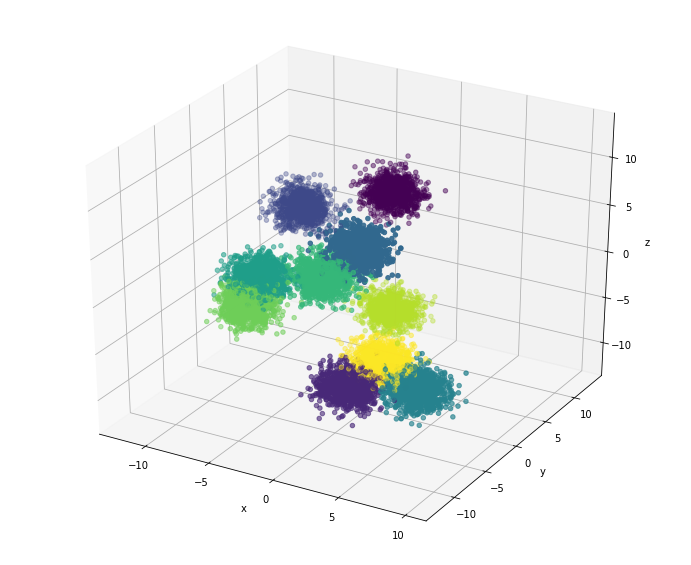

In [7]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [9]:
sc = SparkContext(appName="PythonKMeansExample") # exist by default
sqlContext = SQLContext(sc)

In [10]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

In [11]:
df = sqlContext.read.csv(path, header=True) # requires spark 2.0
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

In [12]:
lines = sc.textFile(path)
data = lines.map(lambda line: line.split(","))
data.take(2)

[[u'id', u'x', u'y', u'z'],
 [u'row0',
  u'-6.077699676970267',
  u'-2.9096103057273632',
  u'-1.5181728865169748']]

In [13]:
df = data.toDF(['id', 'x', 'y', 'z'])
print (df)
df.show()

DataFrame[id: string, x: string, y: string, z: string]
+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796|

In [14]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+------------+----------+----------+
|           x|         y|         z|
+------------+----------+----------+
|        null|      null|      null|
|  -6.0776997|-2.9096103|-1.5181729|
|  -1.0122601|  7.322841|-5.4424076|
|   -8.297007| 6.3228936| 1.1672047|
|  -3.5071216|  4.784812|-5.4449472|
|   -5.122823|-3.3220499|-0.5069805|
|  -2.4764006|  8.255791|  4.409478|
|   7.3153954| -5.079449| -7.291215|
|  -2.0167463|  9.303454|  7.095179|
|  -0.2338185| -4.892681| 2.1228876|
|    6.565442| -6.855994|-6.7983212|
|  -5.6902847|-6.4827404|-0.9246967|
|-0.017986143| 2.7632365| -8.814824|
|  -6.9042625|-6.1491723|-3.5354295|
|  -10.389865|  9.537853|  0.674591|
|   3.9688683|-6.0467844| -5.462389|
|   -7.337052|-3.7689247| -5.261122|
|   -8.991589|  8.738728|  3.864116|
| -0.18098584|  5.482743| -4.900118|
|   3.3193955|-6.3573766| -6.978025|
+------------+----------+----------+
only showing top 20 rows



In [15]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
|   id|        null|      null|      null|
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
+-----+----

In [16]:
df = df.na.drop()
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

In [17]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996612548...|
| row1|[-1.0122600793838...|
| row2|[-8.2970066070556...|
| row3|[-3.5071215629577...|
| row4|[-5.1228232383728...|
| row5|[-2.4764006137847...|
| row6|[7.31539535522460...|
| row7|[-2.0167462825775...|
| row8|[-0.2338185012340...|
| row9|[6.56544208526611...|
|row10|[-5.6902847290039...|
|row11|[-0.0179861430078...|
|row12|[-6.9042625427246...|
|row13|[-10.389864921569...|
|row14|[3.96886825561523...|
|row15|[-7.3370518684387...|
|row16|[-8.9915885925292...|
|row17|[-0.1809858381748...|
|row18|[3.31939554214477...|
|row19|[-2.0266335010528...|
+-----+--------------------+
only showing top 20 rows



In [18]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

Text(0,0.5,u'cost')

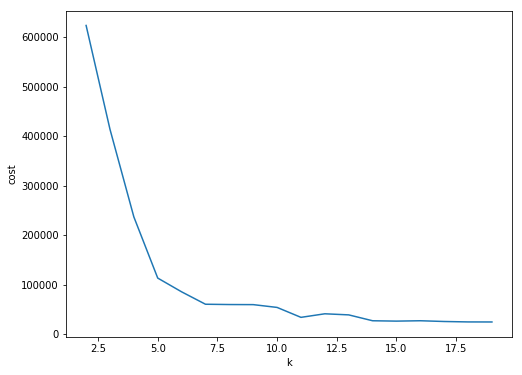

In [19]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [20]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-6.3221623  -3.89627988  0.56177749]
[ 6.6168282  -5.69556677 -6.27473166]
[-0.31260155  3.77092519 -7.55332038]
[-2.46074836  9.0641161   4.6330292 ]
[-1.31238277 -4.21721709  2.23366874]
[-7.22603128 -4.18231902 -2.7139529 ]
[-8.79877678  7.30752724  2.00242494]
[ 2.08432973 -6.33907489 -7.50628741]
[ 4.11111715 -9.61155031  9.41405178]
[ 1.89907573 -7.55465114 -6.34695237]


In [21]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id=u'row0', prediction=5), Row(id=u'row1', prediction=2), Row(id=u'row2', prediction=6)]


In [22]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         5|
| row1|         2|
| row2|         6|
| row3|         2|
| row4|         0|
| row5|         3|
| row6|         1|
| row7|         3|
| row8|         4|
| row9|         1|
|row10|         0|
|row11|         2|
|row12|         5|
|row13|         6|
|row14|         9|
|row15|         5|
|row16|         6|
|row17|         2|
|row18|         7|
|row19|         4|
+-----+----------+
only showing top 20 rows



In [23]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-------+----------+----------+----------+----------+
|     id|prediction|         x|         y|         z|
+-------+----------+----------+----------+----------+
|row1093|         6| -7.601147|  7.069047|  1.564275|
|row1099|         4|-0.7107884|-3.3169584|  2.488001|
| row119|         5| -9.524287| -5.396073|-3.3982348|
|row1191|         2|-0.8568603|  2.037963|-10.700185|
|row1352|         2| -1.669029|  6.943214|-6.0198708|
|row1586|         1|  8.243615|-6.7687254| -6.591385|
|row1766|         8| 3.5482397|  -9.91293|  9.635929|
|row2684|         2|-0.5487077|    6.2472|-4.9076533|
|row2770|         3|-2.4884038| 8.2862835| 4.4569826|
|row2883|         1|  7.196379|-5.0276275| -4.923547|
|row3313|         2|-1.3719763| 4.7211256|-5.1501107|
| row332|         6|-7.6491013|  7.990768| 1.9940823|
|row3374|         2| 1.9008663| 2.4249678| -8.085093|
|row3376|         0|  -5.62288|-2.5612633|0.39997813|
|row4049|         4|-1.7804127|-4.6741023| 2.5568235|
|row4152|         6| -9.1510

In [24]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row1093,6,-7.601147,7.069047,1.564275
row1099,4,-0.710788,-3.316958,2.488001
row119,5,-9.524287,-5.396073,-3.398235
row1191,2,-0.856860,2.037963,-10.700185
row1352,2,-1.669029,6.943214,-6.019871


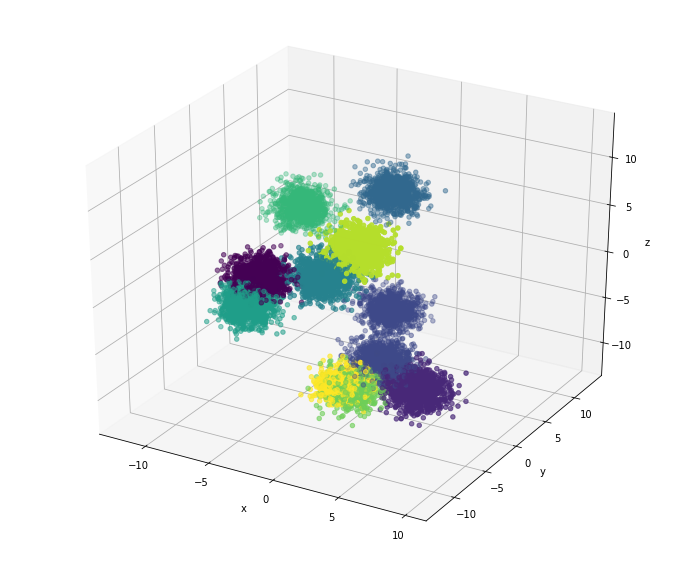

In [25]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [26]:
sc.stop()